**Toxic comment classification**

Character-level and word-level RNN  
Genereally, word-level is better as it has to make less predictions, hence, less error prone  
Also, also its easier to train than characeter-level (Cross entropy loss)

Loss function: Not accuracy (coz, the data is highly imbalanced)
Use: Hamming loss, log loss

Stemming,lemmatising

CNN vs RNN  
depends on how much of a task is dependent. If the length is imp, eg: QnAs, translation. . GO WITH RNN  
Else, if feature dedtction in text is more imp, eg: angry, sad, abuses. .  GO FOR CNN

In [1]:

import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer

In [2]:
from keras import regularizers, initializers, optimizers, callbacks
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.utils.np_utils import to_categorical
from keras.layers import *
from keras.models import Model

Using TensorFlow backend.


In [29]:
MAX_NB_WORDS = 100000    # max words for tokenizer
MAX_SEQUENCE_LENGTH = 400 # max length sentence including pads, we chose this len because it will cover 80% of data 
VALIDATION_SPLIT = 0.2   
EMBEDDING_DIM = 200     
GLOVE_DIR = "glove.6B/glove.6B."+str(EMBEDDING_DIM)+"d.txt"

In [14]:
import numpy as np
import pandas as pd
df = pd.read_csv('data/train.csv')
df = df.drop(columns=['id'])

In [15]:
df['comment_text'] = df['comment_text'].apply(lambda x: x.strip().lower())
df['comment_text'] = df['comment_text'].apply(lambda x: re.sub('[^a-zA-z0-9\s]','',x))
df['comment_text'] = df['comment_text'].apply(lambda x: ' '.join(x.split()))


In [16]:
df.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,explanation why the edits made under my userna...,0,0,0,0,0,0
1,daww he matches this background colour im seem...,0,0,0,0,0,0
2,hey man im really not trying to edit war its j...,0,0,0,0,0,0
3,more i cant make any real suggestions on impro...,0,0,0,0,0,0
4,you sir are my hero any chance you remember wh...,0,0,0,0,0,0


In [17]:
data = df['comment_text'].to_numpy()
label = df.loc[:, df.columns != 'comment_text'].to_numpy()
label = np.any(label, axis=1)  # label comment as toxic if any form of misbehaviour is spotted

data.shape, label.shape

((159571,), (159571,))

In [18]:
np.unique(label, return_counts=True)

(array([False,  True]), array([143346,  16225]))

In [19]:
good = data[label == False]
np.random.seed(7)
np.random.shuffle(good)
good = good[:16225]
y_good = np.zeros(len(good))

bad = data[label == True]
y_bad = np.ones(len(bad))

X = np.hstack((good, bad))
y = np.hstack((y_good, y_bad))

X.shape, y.shape

((32450,), (32450,))

In [20]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(
    X, y, test_size=0.2, random_state=7)

print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(25960,) (25960,)
(6490,) (6490,)


In [21]:
Y_train.shape, Y_test.shape

((25960,), (6490,))

counting how many words are there in each type of toxic comment 


removing stop words, punctuations, making lowercase

In [22]:
type(X_train)

numpy.ndarray

Finding avg length avg length and total length distribution 

In [24]:
X_train.shape

(25960,)

In [26]:
print('Sample data:', X_train[1], Y_train[1])

Sample data: you better believe it wikipeida will not be allow to be use as a political sword by du there is to much at stake and its credibility will be attacked and diminished it would be naive to think otherwise unless your a wikijuice drinking idiot i am assembling a crew right now and this will be the battle ground for 08 with guys like propol and his buds ruling here this will be the order of battle 0.0


**oov_token** (if it ever sees a new word)

In [27]:
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, oov_token = True)
tokenizer.fit_on_texts(X_train)

In [28]:
sequences = tokenizer.texts_to_sequences(X_train)
word_index = tokenizer.word_index
print('Vocabulary size:', len(word_index))

Vocabulary size: 67388


In [30]:
sequences2 = tokenizer.texts_to_sequences(X_test)
word_index2 = tokenizer.word_index
print('Vocabulary size:', len(word_index2))

Vocabulary size: 67388


In [31]:
sequences[0]

[322,
 10080,
 10080,
 117,
 11325,
 1205,
 15,
 36,
 1707,
 29,
 15378,
 39,
 5,
 853,
 2755,
 4,
 19,
 5,
 1169,
 159,
 3867,
 5,
 853,
 708,
 94,
 5,
 1850,
 4353,
 3017,
 25,
 22,
 503,
 15,
 5387,
 392,
 97,
 4,
 79,
 37,
 3,
 357,
 105,
 85,
 3,
 104,
 12905,
 322,
 877,
 2263,
 116,
 3,
 63,
 37,
 51,
 122,
 5,
 2391,
 54,
 73,
 3694,
 109,
 2,
 11326,
 6,
 540,
 10,
 387,
 3,
 5,
 4209,
 38,
 1751,
 1084,
 1066,
 17,
 871,
 9,
 46,
 73,
 1391,
 109,
 28,
 310,
 50,
 159,
 48,
 5,
 4808,
 11,
 5,
 4354,
 10,
 15379,
 17,
 248,
 1829,
 4,
 207,
 3,
 1313,
 4,
 28,
 339,
 36,
 60,
 179,
 209,
 29011,
 4,
 670,
 23,
 10,
 387,
 530,
 10081]

In [33]:

data = pad_sequences(sequences, padding = 'post', maxlen = MAX_SEQUENCE_LENGTH)

print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', Y_train.shape)

Shape of data tensor: (25960, 400)
Shape of label tensor: (25960,)


In [34]:
data2 = pad_sequences(sequences2, padding = 'post', maxlen = MAX_SEQUENCE_LENGTH)

print('Shape of data tensor:', data2.shape)
print('Shape of label tensor:', Y_test.shape)

Shape of data tensor: (6490, 400)
Shape of label tensor: (6490,)


In [35]:
num_validation_samples = int(VALIDATION_SPLIT*data.shape[0])
x_train = data[: -num_validation_samples]
y_train = Y_train[: -num_validation_samples]
x_val = data[-num_validation_samples: ]
y_val = Y_train[-num_validation_samples: ]

In [36]:
x_train.shape, x_val.shape

((20768, 400), (5192, 400))

In [38]:
print('Tokenized sentences: \n', x_train[0])
print('One hot label: \n', y_train[0])

Tokenized sentences: 
 [  322 10080 10080   117 11325  1205    15    36  1707    29 15378    39
     5   853  2755     4    19     5  1169   159  3867     5   853   708
    94     5  1850  4353  3017    25    22   503    15  5387   392    97
     4    79    37     3   357   105    85     3   104 12905   322   877
  2263   116     3    63    37    51   122     5  2391    54    73  3694
   109     2 11326     6   540    10   387     3     5  4209    38  1751
  1084  1066    17   871     9    46    73  1391   109    28   310    50
   159    48     5  4808    11     5  4354    10 15379    17   248  1829
     4   207     3  1313     4    28   339    36    60   179   209 29011
     4   670    23    10   387   530 10081     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0    

In [39]:
embeddings_index = {}
f = open(GLOVE_DIR)
print('Loading GloVe from:', GLOVE_DIR,'...', end='')
for line in f:
    values = line.split()
    word = values[0]
    embeddings_index[word] = np.asarray(values[1:], dtype='float32')
f.close()
print("Done.\n Proceeding with Embedding Matrix...", end="")

embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
print(" Completed!")

Loading GloVe from: glove.6B/glove.6B.200d.txt ...Done.
 Proceeding with Embedding Matrix... Completed!


In [40]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedding_layer = Embedding(len(word_index) + 1,
                           EMBEDDING_DIM,
                           weights = [embedding_matrix],
                           input_length = MAX_SEQUENCE_LENGTH,
                           trainable=False,
                           name = 'embeddings')
embedded_sequences = embedding_layer(sequence_input)

making Sequential neural network using **Model()** API

In [45]:
x = LSTM(60, return_sequences=True,name='lstm_layer')(embedded_sequences)
x = GlobalMaxPool1D()(x)
x = Dropout(0.1)(x)
x = Dense(50, activation="relu")(x)
x = Dropout(0.1)(x)
preds = Dense(1, activation="sigmoid")(x)

In [46]:
model = Model(sequence_input, preds)
model.compile(loss = 'binary_crossentropy',
             optimizer='adam',
             metrics = ['accuracy'])
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 400)               0         
_________________________________________________________________
embeddings (Embedding)       (None, 400, 200)          13477800  
_________________________________________________________________
lstm_layer (LSTM)            (None, 400, 60)           62640     
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 60)                0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 60)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 50)                3050      
_________________________________________________________________
dropout_4 (Dropout)          (None, 50)                0   

In [47]:
import timeit 

In [48]:
start_time = timeit.default_timer()

print('Training progress:')
history = model.fit(x_train, y_train, epochs = 2, batch_size=32, validation_data=(x_val, y_val))

elapsed_pa = timeit.default_timer() - start_time


Training progress:
Train on 20768 samples, validate on 5192 samples
Epoch 1/2
20768/20768 [==============================] - 157s 8ms/step - loss: 0.3104 - accuracy: 0.8654 - val_loss: 0.2255 - val_accuracy: 0.9041
Epoch 2/2
20768/20768 [==============================] - 148s 7ms/step - loss: 0.2284 - accuracy: 0.9060 - val_loss: 0.2106 - val_accuracy: 0.9124


In [49]:
print(elapsed_pa)

305.3944774360001


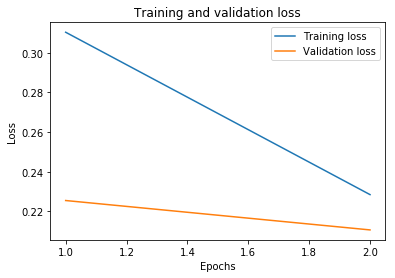

In [52]:
import matplotlib.pyplot as plt
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss)+1)

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show();

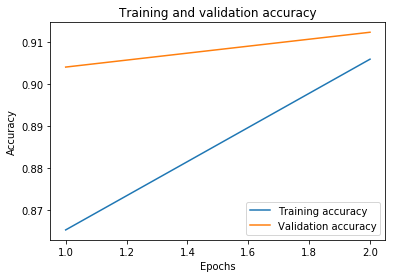

In [51]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

plt.plot(epochs, accuracy, label='Training accuracy')
plt.plot(epochs, val_accuracy, label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.show();

In [53]:
predict = model.predict(data2)

In [54]:
predict

array([[0.9973074 ],
       [0.00624099],
       [0.02796084],
       ...,
       [0.0030899 ],
       [0.01410614],
       [0.9719902 ]], dtype=float32)

In [55]:
from sklearn.metrics import hamming_loss
from sklearn.metrics import accuracy_score

In [58]:

predict = np.round(predict)
accuracy = accuracy_score(Y_test,predict)
print("Accuracy : {}".format(accuracy*100))

Accuracy : 90.47765793528505


In [59]:
from sklearn.metrics import precision_recall_fscore_support as prfs

In [62]:
precision, recall, fscore, _ = prfs(Y_test, predict > 0.5, average='micro')
precision, recall, fscore

(0.9047765793528505, 0.9047765793528505, 0.9047765793528505)